# **Experiment:** *In vitro* phantom experiments

This notebook reproduces the results of the numerical experiments in

> C. Arrieta and C. A. Sing Long, "*Exact Local Recovery for Chemical Shift Imaging*."

You can use the following code to cite our work.
```bibtex
@article{arrieta_exact_2025, 
  title   = {Exact Local Recovery for Chemical Shift Imaging},  
  author  = {Arrieta, Cristóbal and Sing Long, Carlos A.}, 
  date    = {2025-03-31}
}
```

In [1]:
import numpy as np
import cvxpy as cp
import scipy.io as scpio
import h5py

from os.path import exists

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

In [2]:
# load precomputed data
LOAD_DATA = True
# layout for plots
PLT_LAYOUT = 'constrained'
BBOX_INCHES = Bbox([ [0, 0], [6, 6] ])
# save figures
def savefig(fname):
  plt.savefig(f'FIG/E04_{fname:s}.png', bbox_inches=BBOX_INCHES, dpi=300)
  plt.savefig(f'FIG/E04_{fname:s}.eps', bbox_inches=BBOX_INCHES)

## Contents

1. [Loading data](#loading-data)
2. [Setting up the problem](#setting-up-the-problem)
3. [Solving the problem](#solving-the-problem)
4. [Figures](#figures)

## Loading data

Load data for an *in vitro* phantom containing water, fat and silicone. It uses 6 echo times. **The data is not provided in this repository but it is publicly available [here](https://syncandshare.lrz.de/getlink/fi2yT7Vp761X2EW2XbY41KnM/)**. 

If you are interested in using this phantom, **we kindly request you to cite the following paper**:

> J. K. Stelter, C. Boehm, S. Ruschke, K. Weiss, M. N. Diefenbach, M. Wu, T. Borde, G. P. Schmidt, M. R.
Makowski, E. M. Fallenberg, and D. C. Karampinos, "Hierarchical multi-resolution graph-cuts for water-fat-
silicone separation in breast MRI," IEEE Transactions on Medical Imaging, vol. 41, no. 11, pp. 3253–3265, Nov. 2022. DOI: [10.1109/TMI.2022.3180302](https://doi.org/10.1109/TMI.2022.3180302).

In [3]:
# number of species
ns = 3
# names
SPECIES = [ 'WATER', 'FAT', 'SILICONE' ]
# undersampling in spatial dimensions
usamp = 1
# phantom code
DTE = '0.986'
# filename
#   download the publicly available phantom in https://syncandshare.lrz.de/getlink/fi2yT7Vp761X2EW2XbY41KnM/
#   from Stelter et al. (2022) IEEE TMI, DOI: 10.1109/TMI.2022.3180302
fname = 'phantom_shortest.h5'  
# source folder
folder = '../../data/phantoms/stelter/phantom/'
# load .h5 file
data = h5py.File(folder + fname, 'r')
# signal
#   get central slice of the phantom
So = data['multiecho'][::usamp, ::usamp, 64, 0, :].squeeze()
#   normalize signal
So = So/np.max(np.abs(So))
# echo times
params = {}
params.update(data['multiecho'].attrs)
te = params['TE_s']
# field
field = params['fieldStrength_T']

Echo times and echo spacing
   Echo time  0 : 0.001238 s
   Echo time  1 : 0.002224 s  (Interval : 0.000986 s)
   Echo time  2 : 0.003210 s  (Interval : 0.000986 s)
   Echo time  3 : 0.004196 s  (Interval : 0.000986 s)
   Echo time  4 : 0.005182 s  (Interval : 0.000986 s)
   Echo time  5 : 0.006168 s  (Interval : 0.000986 s)


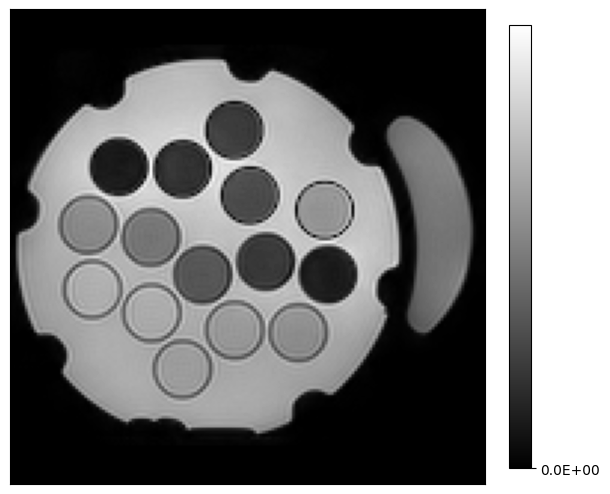

In [4]:
# number of echo times
ne = te.size
# image shape
imshape = So.shape[:-1]
# number of pixels
npx = np.prod(So.shape[:-1])
# true signal
so = So.reshape((npx, ne))
# maximum signal value
So_max = np.abs(So).max()
# signal norm
so_nrm = np.linalg.norm(so, axis=1)

print(f'Echo times and echo spacing')
for I in range(ne):
  if I > 0:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s  (Interval : {te[I] - te[I-1]:.6f} s)')
  else:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s')
  
# plot phantom
plt.figure(figsize=(6, 6), layout='constrained')
plt.imshow(np.abs(So[:, :, 0]), cmap='gray', aspect='equal')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, so_nrm.max() ])
plt.show()

We get the chemical shifts for the water, fat and silicone. 

In [5]:
from CSITools.routines.models import get_wfsilicone_phantom_model

In [6]:
shifts, weights = get_wfsilicone_phantom_model(field, mp=True)

## Setting up the problem

The residuals are implemented in the code as the ``CSIMap`` class. 

In [7]:
from CSITools.objects.csimap import CSIMap

In [8]:
R = CSIMap(So, te, shifts, weights, field, stol=0.0)

## Solving the problem

The Proximal Gradient Descent (PGD) solver regularizes the squared loss
$$
  L_R({\boldsymbol \xi}) = \frac{1}{2}\sum_{x} \|{\boldsymbol R}(\xi_x) {\boldsymbol s}_x\|_2^2
$$
with one of the convex and prox-capable regularizers provided. In this notebook we do not explicitly regularize, but we impose a constraint on the bound of the gradient by using the sum of indicator functions
$$
  P({\boldsymbol \xi}) = \mathbb{I}\{\operatorname{real}({\boldsymbol \xi}) \in C\} + \mathbb{I}\{\operatorname{imag}({\boldsymbol \xi}) \geq 0\}
$$
where
$$
  C = \{{\boldsymbol \phi} :\,\, \|\nabla{\boldsymbol \phi}_x \|_2 \leq \delta_x,\, x\in \Omega\}
$$
using Projected Gradient Descent (PGD).

The solver for this problem is implemented in ``CSIToolsSolverPGD``. 

In [9]:
from CSITools.solvers.pgd import CSIToolsSolverPGD

The solver requires an ``CSIMap`` instance.

In [10]:
solver = CSIToolsSolverPGD(R)

The solver also needs an instance of ``CSIToolsProx`` object. If no proximal operator is given, then it simply solves the NLS problem. Here we use the indicator function for the set above.

In [11]:
from CSITools.objects.prox import CSIToolsProxGradientBound

Here we can provide a single value $\varepsilon_g(v) \equiv \varepsilon_g$ or an array of bounds. Since ``RIDEALProxGradientBound`` uses forward finite-differences to compute the gradient, the number of bounds for an image of shape ``shape`` is ``(shape[0] - 1)*(shape[1] - 1)``.

In [12]:
# bound for regular voxels
gbnd = 20.0
# dimensional array
_gbnd = gbnd * np.ones((imshape[0]-1, imshape[1]-1))
# adjust the bound for voxels with zero signal intensity
So_nrm = so_nrm.reshape(So.shape[:2])
_gbnd[So_nrm[:imshape[0]-1, :imshape[1]-1] < 1E-1] = 1000

Pgbnd = CSIToolsProxGradientBound(shape=R.im_shape, gbound=_gbnd)

Some basic options can be set. More can be found on ``options``.

In [13]:
solver.options['max_itns'] = 1000
solver.options['print_every'] = 100
solver.options['stepRelTol'] = 1E-7
solver.options['stepAbsTol'] = 1E-4

Set the initial iterate and initial stepsize.

In [14]:
# initial iterate
xi_init = np.ones(imshape)
# initial stepsize
t = 1E+3

The solver handles three modes depending on an additional constraint in which only the fieldmap is minimized, i.e., the real part of ${\boldsymbol\xi}$, only $R_2^*$ is minimized, i.e., the imaginary part of ${\boldsymbol\xi}$, or both. These are used with ``mode='f'``, ``mode='r'`` and ``mode='both'`` respectively. ``mode='both'`` is the default.

Internally the optimization variable is always complex. If the initial iterate is complex and ``mode='f'`` or ``mode='r'`` is used, then the corresponding imaginary or real part is preserved. This is useful to optimize over a fixed variable.

We can provide in ``prox`` a single ``CSIToolsProx``. 

In [15]:
# filename
fname = f'DAT/E04_RECOVERY_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}_2.npz'

if LOAD_DATA and exists(fname):
  xi_rec = np.load(fname)['xi_rec']
else:
  xi_rec = solver.solve(xi_init, t, prox=Pgbnd, mode='both')
  # save
  np.savez_compressed(fname, xi_rec=xi_rec)

itn     | obj(x)    | |x|       | |g|       | |dx|      | t         | ls itn | min(r)    | max(r)   
0000001 | 8.879E+02 | 1.600E+02 | 2.954E-01 | 2.954E+02 | 1.000E+03 |      0 | 0.000E+00 | 1.452E+00


/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0000100 | 1.336E+01 | 3.033E+03 | 1.016E-02 | 8.068E+00 | 1.000E+03 |      0 | 0.000E+00 | 3.327E+01
0000200 | 7.031E+00 | 3.211E+03 | 5.644E-03 | 3.646E+00 | 1.000E+03 |      0 | 0.000E+00 | 5.387E+01
0000300 | 5.456E+00 | 3.287E+03 | 3.983E-03 | 2.135E+00 | 1.000E+03 |      0 | 0.000E+00 | 7.115E+01
0000400 | 4.797E+00 | 3.330E+03 | 3.260E-03 | 1.607E+00 | 1.000E+03 |      0 | 0.000E+00 | 8.298E+01
0000500 | 4.322E+00 | 3.363E+03 | 2.858E-03 | 1.476E+00 | 1.000E+03 |      0 | 0.000E+00 | 8.819E+01
0000600 | 3.918E+00 | 3.390E+03 | 2.578E-03 | 1.346E+00 | 1.000E+03 |      0 | 0.000E+00 | 8.977E+01
0000700 | 3.626E+00 | 3.414E+03 | 2.339E-03 | 1.060E+00 | 1.000E+03 |      0 | 0.000E+00 | 9.017E+01
0000800 | 3.473E+00 | 3.432E+03 | 2.149E-03 | 7.016E-01 | 1.000E+03 |      0 | 0.000E+00 | 9.026E+01
itn     | obj(x)    | |x|       | |g|       | |dx|      | t         | ls itn | min(r)    | max(r)   
0000900 | 3.401E+00 | 3.445E+03 | 2.055E-03 | 5.050E-01 | 1.000E+03 |      0 | 0.000E+00 | 

To obtain the predicted voxel signals and concentrations we use ``signal`` and ``concentrations`` from the ``CSIMap``.

In [16]:
# predicted concentrations
c = R.concentration(xi_rec)
# predicted signal
S = R.signal(xi_rec)
# predicted pdff
pdff = np.abs(c[:, :, 1]) / np.maximum(1E-32, np.linalg.norm(c, axis=2, ord=1))

Plot results.

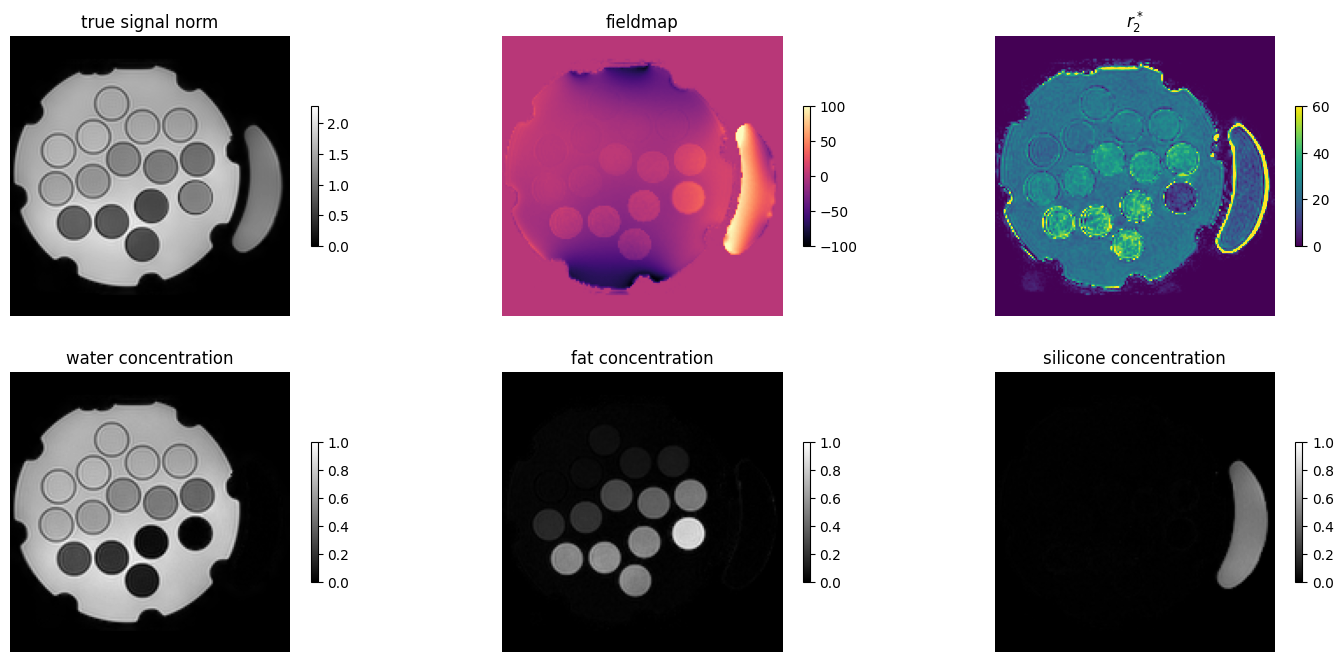

In [17]:
# PDFF HOT
# FIELDMAP MAGMA
# R2* VIRIDIS
# CONCENTRATIONS GRAY

fo_max = -100
f_rec_max = 100

fig, axs = plt.subplots(2, 3, figsize=(18, 8))
# first row
_axs = axs[0]

im0 = _axs[0].imshow(np.linalg.norm(So, axis=2), cmap='gray', aspect='equal')
_axs[0].axis('off')
_axs[0].set_title('true signal norm')
plt.colorbar(im0, ax=_axs[0], shrink=0.5)

im1 = _axs[1].imshow(xi_rec.real, cmap='magma', vmin=-100, vmax=100, aspect='equal')
_axs[1].axis('off')
_axs[1].set_title('fieldmap')
plt.colorbar(im1, ax=_axs[1], shrink=0.5)

im2 = _axs[2].imshow(xi_rec.imag*2*np.pi, cmap='viridis', vmin=0, vmax=60, aspect='equal')
_axs[2].axis('off')
_axs[2].set_title('$r_2^*$')
plt.colorbar(im2, ax=_axs[2], shrink=0.5)

# second row
_axs = axs[1]

im3 = _axs[0].imshow(np.abs(c[:,:,0]), cmap='gray', vmin=0, vmax=1, aspect='equal')
_axs[0].axis('off')
_axs[0].set_title('water concentration')
plt.colorbar(im3, ax=_axs[0], shrink=0.5)

im4 = _axs[1].imshow(np.abs(c[:,:,1]), cmap='gray', vmin=0, vmax=1, aspect='equal')
_axs[1].axis('off')
_axs[1].set_title('fat concentration')
plt.colorbar(im4, ax=_axs[1], shrink=0.5)

im5 = _axs[2].imshow(np.abs(c[:,:,2]), cmap='gray', vmin=0, vmax=1, aspect='equal')
_axs[2].axis('off')
_axs[2].set_title('silicone concentration')
plt.colorbar(im5, ax=_axs[2], shrink=0.5)

plt.show()

## Quantitative comparison against Magnetic Resonance Spectroscopy (MRS)

    Ground truth PDFF obtained with MRS:
 [[  0.        ]
 [  2.59071836]
 [  6.26285179]
 [  8.58327405]
 [ 11.49812872]
 [ 16.77242288]
 [ 21.92869779]
 [ 33.80262585]
 [ 43.76564357]
 [ 54.07685908]
 [ 64.11594022]
 [ 73.82935738]
 [ 82.36446377]
 [ 91.17013284]
 [100.        ]] 

    Estimated PDFF mean and standard deviation: 
[[ 3.27494592  0.59894593]
 [ 5.29016778  0.45340052]
 [ 7.90263513  0.438777  ]
 [10.1785891   0.39051921]
 [12.91171684  0.63325157]
 [18.64644905  0.43472964]
 [23.5404475   0.50763492]
 [33.34213721  0.44198795]
 [43.32997812  0.46856743]
 [53.10507823  0.87610904]
 [63.69108356  0.92407151]
 [73.16698757  1.17633609]
 [81.84181231  1.31983477]
 [89.85801469  1.66217931]
 [98.20156922  0.66749415]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


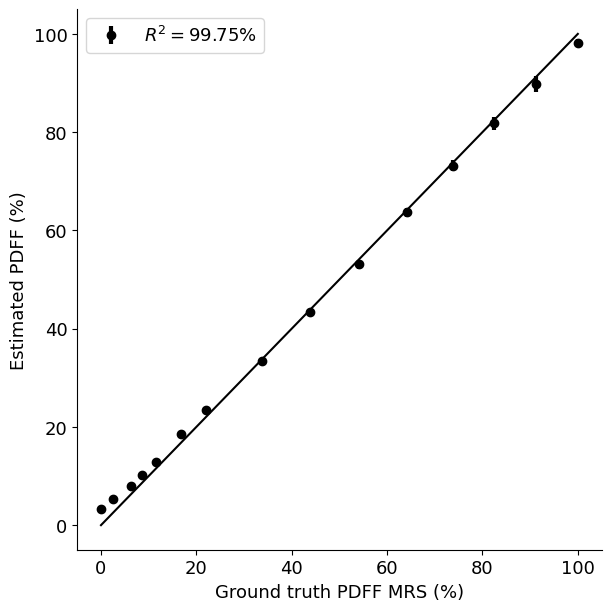

    PDSF (Silicone fraction):   98.09613516176721 pm 0.7822125671520667


In [36]:
import glob

def get_BMRS_quantification(BMRS_obj_path):
    quant = {}
    f = h5py.File(BMRS_obj_path, 'r')
    ref = h5py.File(BMRS_obj_path, 'r')['BMRSobj']['quant'][0, 0]
    data = f[ref]['output']['param']
    for key in data.keys():
        quant[key] = np.squeeze(np.array(data[key]))
    return quant

# Load MRS fitting results
PDFF_TIMGRE = np.zeros((15))
PDFF_MRS = np.zeros((15))
for path in sorted(glob.glob(f'../../data/phantoms/stelter/mrs/*.mat')):
    vial = int(path.split('_')[-1][:-6])
    quant = get_BMRS_quantification(path)
    PDFF_MRS[vial-1] = np.sum(quant['rho'][:-1])/np.sum(quant['rho'])*100
PDFF_MRS[0] = 0

print(f'    Ground truth PDFF obtained with MRS:\n {PDFF_MRS.reshape((15,1))} \n')

vials = [(PDFF_MRS[0], [65, 27]), #1
         (PDFF_MRS[1], [57, 47]), #2 
         (PDFF_MRS[2], [38, 58]), #3
         (PDFF_MRS[3], [51, 75]), #4
         (PDFF_MRS[4], [50, 100]), #5
         (PDFF_MRS[5], [87, 26]), #6
         (PDFF_MRS[6], [83, 48]), #7
         (PDFF_MRS[7], [71, 65]), #8
         (PDFF_MRS[8], [75, 85]), #9
         (PDFF_MRS[9], [71, 107]), #10
         (PDFF_MRS[10], [107, 37]), #11
         (PDFF_MRS[11], [107, 58]), #12
         (PDFF_MRS[12], [120, 76]), #13
         (PDFF_MRS[13], [97, 81]), #14
         (PDFF_MRS[14], [92, 106]),] #15
size = [5, 5, 10]

PDFF = np.zeros((PDFF_MRS.shape[0], 2))

for i, (expected, vial) in enumerate(vials):
    PDFF_tmp = pdff[vial[0]-size[0]:vial[0]+size[0], vial[1]-size[1]:vial[1]+size[1]]*100
    PDFF[i] = (np.mean(PDFF_tmp), np.std(PDFF_tmp))

print(f'    Estimated PDFF mean and standard deviation: \n{PDFF}')

            
colors = ['black']
labels = ['$R^2 = 99.75 \%$']
plt.style.use('default')
plt.rcParams.update({'font.size': 13})
# fig, ax = plt.subplots(figsize=(4*1.5,3*1.5))

fig, ax = plt.subplots(figsize=(6, 6), layout=PLT_LAYOUT)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos = 0

val = []
refs = []
# l = 2*j + k
for i in range(PDFF.shape[0]):
    ref = vials[i][0]
    values = PDFF[i]
    refs.append(ref)
    val.append(values[0])
    if i == 1:
        ax.errorbar(ref, values[0], yerr=values[1], fmt='o',
                    color=colors[0], label=labels[0], elinewidth=3)
    else:
        ax.errorbar(ref, values[0], yerr=values[1], fmt='o',
                    color=colors[0], elinewidth=3)
val = np.array(val)
refs = np.array(refs)
ss_tot = np.sum((val-np.mean(val))**2)
ss_res = np.sum((val-refs)**2)
r2 = 1 - (ss_res / ss_tot)
labels = [f'{r2*100:.2f}']

ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), color='black')
ax.legend()
ax.set_ylabel('Estimated PDFF (%)')
ax.set_xlabel('Ground truth PDFF MRS (%)')
savefig(f'ERRORMRS_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')
plt.show()

# Silicone ROI
size = [15, 5, 0]
roi = [90, 145, 64]
roi_phantom = [80, 70, 64]
size_phantom = [15, 15, 0]

# PDSF evaluation
img = c[:, :, 2]
pdsf = np.abs(c[:, :, 2]) / np.maximum(1E-32, np.linalg.norm(c[:,:,:], axis=2, ord=1))*100

values = pdsf[roi[0]-size[0]:roi[0]+size[0], roi[1]-size[1]:roi[1]+size[1]]
print(f'    PDSF (Silicone fraction):   {np.mean(values)} pm {np.std(values)}')

## Figures

### Signal Norm

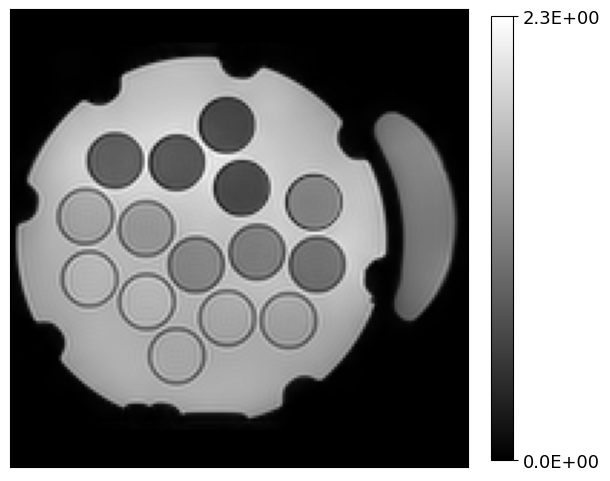

In [37]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(so_nrm.reshape(imshape), origin='lower', vmin=0, vmax=so_nrm.max(), cmap='gray', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, so_nrm.max() ])

savefig(f'SIGNAL_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

### Concentrations

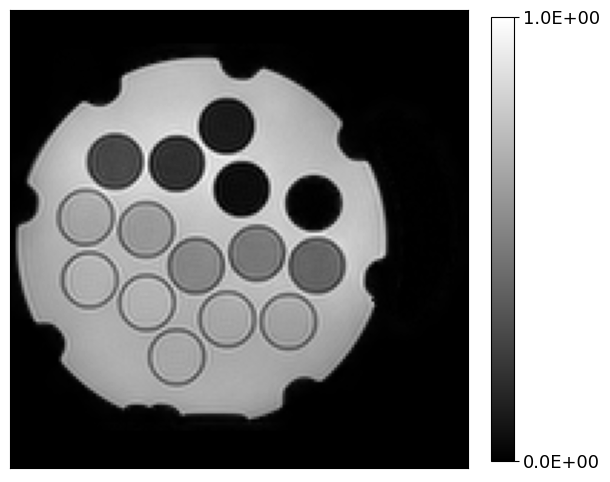

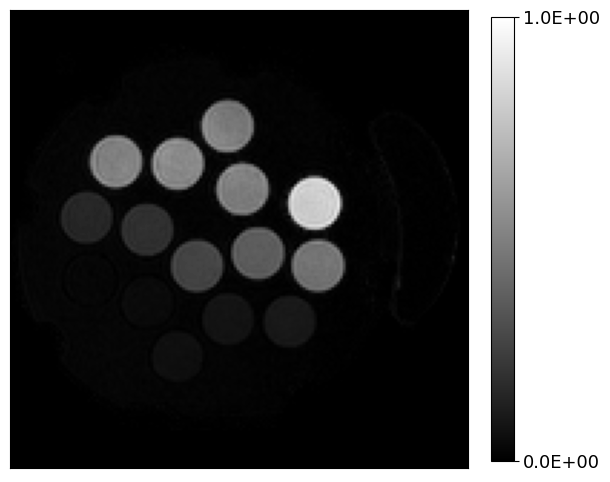

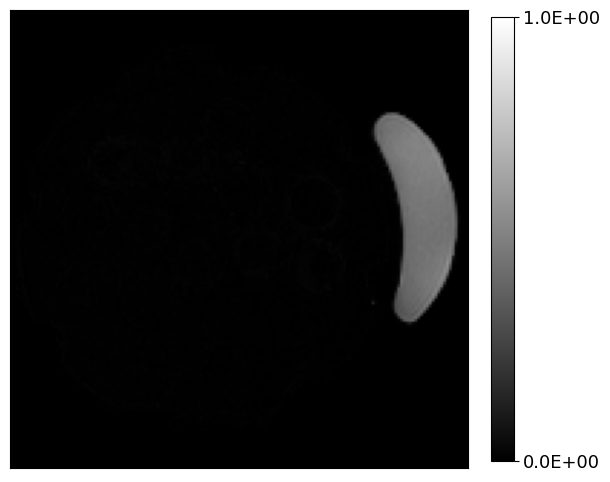

In [38]:
for I, SLABEL in enumerate(SPECIES):
  plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
  plt.imshow(np.abs(c[:, :, I]), origin='lower', vmin=0.0, vmax=np.abs(c).max(), cmap='gray', aspect='auto')
  plt.xlim([ 0, imshape[0] - 1 ])
  plt.ylim([ 0, imshape[1] - 1 ])
  plt.xticks([])
  plt.yticks([])
  plt.axis('scaled')
  plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(c).max() ])

  savefig(f'C_{SLABEL}_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

  plt.show()

### Fieldmap

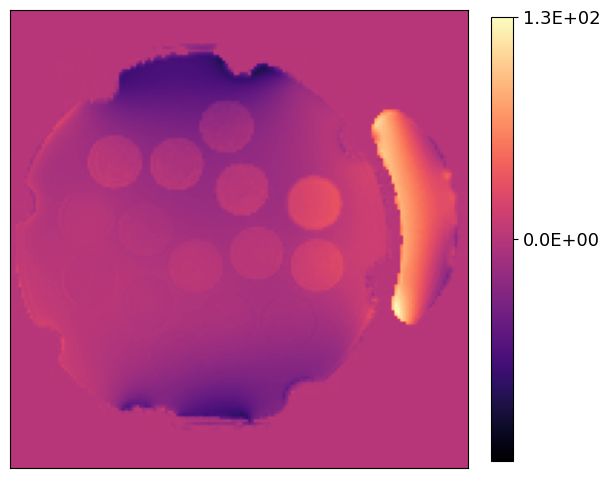

In [39]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(xi_rec.real, origin='lower', vmin=-np.abs(xi_rec.real).max(), vmax=+np.abs(xi_rec.real).max(), cmap='magma', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(xi_rec.real).max() ])

savefig(f'PH_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

### $R_2^*$

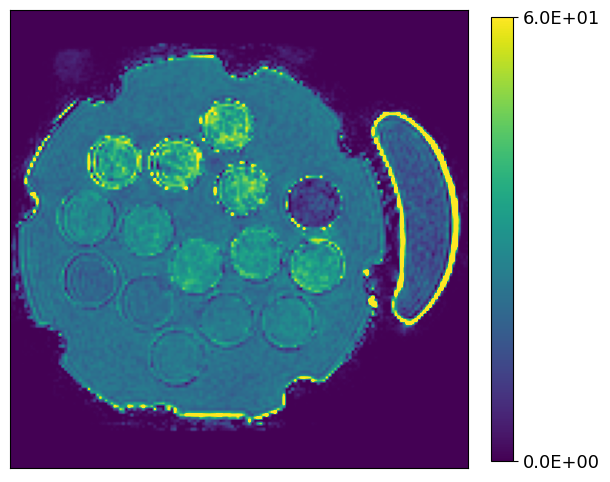

In [40]:
r2_rec = xi_rec.imag*2*np.pi
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(r2_rec, origin='lower', vmin=0, vmax=+60, cmap='viridis', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, 60 ])

savefig(f'R2_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()